# Question 5

## Pre-processing:

In [1]:
from multiprocessing import Pool
from numpy import save
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('./trainData.csv')
test = pd.read_csv('./testData.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head(3)

,Unnamed: 0,user_id,business_id,stars,text
0,0,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5.0,Super simple place but amazing nonetheless. It...
1,1,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5.0,Small unassuming place that changes their menu...
2,2,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5.0,Lester's is located in a beautiful neighborhoo...


## Features
We will be using two main features the text mode:
1. Pre-trained sentiment analysis model.
2. Pre-trained word embedding model.

For sentiment analysis we've used Polyglot pre-trained model based on: <b>Building sentiment lexicons for all major languages.</b> By Chen, Yanqing and Skiena, Steven. (https://www.aclweb.org/anthology/P14-2063.pdf)

For word embeddings we've used SpaCy <b>en_core_web_lg</b>: GloVe vectors trained on Common Crawl. (https://spacy.io/models/en#en_core_web_lg)

In [4]:
# !pip install spacy
import spacy
# !python -m spacy download en_core_web_lg
import en_core_web_lg

nlp_en = spacy.load('en')
word_embeddings = en_core_web_lg.load()

# !pip install polyglot
# !pip install pycld2 pyicu morfessor
# !sudo apt-get install python-numpy libicu-dev
# !polyglot download sentiment2.en sentiment2.fr

from polyglot.text import Text

### Sentitment analysis examlple

In [9]:
good_sentence = 'The schnitzel tastes good'
bad_sentence = 'The schnitzel tastes bad'
print('Sentence: %s - Polarity value: %s' % (good_sentence, Text(good_sentence).polarity))
print('Sentence: %s - Polarity value: %s' % (bad_sentence, Text(bad_sentence).polarity))

Sentence: The schnitzel tastes good - Polarity value: 1.0
Sentence: The schnitzel tastes bad - Polarity value: -1.0


### Word embedding example:

In [13]:
nlp_en(good_sentence).vector

array([-0.9114693 ,  0.7643397 , -0.13391006, -0.55225426,  2.9559462 ,
       -0.57415223,  2.1061962 , -0.9522961 ,  1.5902431 ,  0.4614852 ,
       -1.2936845 ,  0.7127428 ,  0.29019094,  1.2715446 , -0.7468778 ,
       -0.0960201 , -2.0786645 , -1.1211485 , -0.999015  , -1.5393571 ,
        1.8427663 ,  0.42068043, -1.7615972 , -0.32483393,  0.9325883 ,
        0.75593686, -0.78313994, -1.3573792 ,  0.19013476,  0.31226802,
       -0.45489317,  1.889648  , -1.2618005 , -0.7740066 , -0.01927185,
       -1.3993042 ,  1.2173991 ,  0.13923384, -1.8764429 ,  0.6271461 ,
        2.2260892 ,  0.21308854,  0.07156163, -1.2292256 ,  1.1435161 ,
       -0.42475027,  0.79920256, -0.11738998, -0.47466668,  2.9813936 ,
        0.85535884, -0.03741038, -0.9331693 , -2.1958532 , -2.4001408 ,
       -0.13666493,  1.5210004 ,  0.13124412, -0.5608901 ,  0.39753455,
        1.1663913 ,  2.189408  , -0.00373243, -0.981498  ,  2.3745198 ,
        0.77494216,  0.5314827 , -2.9572294 , -1.9545283 , -0.67

Each text will be processed like this:
1. <b>Tokenization</b>.
2. <b>Lemmatization</b>: The reason we use lemmatization and not stemming is because we NEED the words to be actual words when using pre-modeled word embeddings.
3. We are NOT removing stop words. It's not effective on sentiment analysis because some of the stop words are words like 'no' and 'not' which change the whole sentence meaning when they appear.
4. <b>Sentitment analysis</b> - We will get polarity score between -1 (Bad) and 1 (Good) where 0 should be natural.
5. <b>Word embeddings</b>. 

In [14]:
from spacy.lang.en import TAG_MAP 

def get_sentence_with_lemmas(sentence):
    if isinstance(sentence, str):
        return nlp_en(' '.join(word.lemma_ for word in nlp_en(sentence)))
    if isinstance(sentence, float):
        get_sentence_with_lemmas(str(sentence))
    return nlp_en(' '.join(word.lemma_ for word in sentence))

def get_sentence_vector(sentence):
    if isinstance(sentence, str):
        return word_embeddings(sentence).vector
    return word_embeddings(str(sentence)).vector

def remove_stop_words(sentence):
    return nlp_en(''.join(word.string for word in sentence if not word.is_stop))

def get_sentitment_analysis_polarity(sentence):
    try:
        return np.array([Text(sentence.replace('\n', '')).polarity])
    except:
    # print(sentence)
    # text = Text(sentence)
    # print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
    # for w in text.words:
    #     print("{:<16}{:>2}".format(w, w.polarity))
        return np.zeros((1))

def save_numpy(np_array, name):
    from numpy import save
    save(name+'.npy', np_array)
    
def load_numpy(name):
    from numpy import load
    return load(name+'.npy', allow_pickle=True)

def preprocess_text(text):
    lemma_sentence = get_sentence_with_lemmas(text)
    # no_stop_words_sentence = get_sentence_with_lemmas(lemma_sentence)
    sentiment_analysis = get_sentitment_analysis_polarity(text)
    return np.concatenate((get_sentence_vector(lemma_sentence), sentiment_analysis))

assert np.array_equal(get_sentence_vector(nlp_en('The waiter was quick and polite.')), get_sentence_vector('The waiter was quick and polite.'))
assert 'the waiter be quick and polite .' == str(get_sentence_with_lemmas('The waiter was quick and polite.'))
assert 'waiter quick polite.' == str(remove_stop_words(nlp_en('The waiter was quick and polite.')))
assert np.ones((1)) == get_sentitment_analysis_polarity('very good')

len(list(TAG_MAP.keys()))

def df_apply(df):
    return df.apply(lambda text: preprocess_text(text))

LIMIT = 250000
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    print('Starting up the engine.')
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

Because of memory limitations we had to run feature extraction batches sized 250k.
Then we've saved those array into files. 

The arrays were sized 301: 300 [Word embedding] and 1 [Sentitmenet analysis].

In [ ]:
# train_word_embedding = parallelize_dataframe(train['text'][: LIMIT], df_apply)
# save_numpy(train_word_embedding, 'train_word_embeddings')

# train_word_embedding = parallelize_dataframe(train['text'][LIMIT : LIMIT * 2], df_apply)
# save_numpy(train_word_embedding, 'train_word_embeddings_500k')

# train_word_embedding = parallelize_dataframe(train['text'][LIMIT * 2 : LIMIT * 3], df_apply)
# save_numpy(train_word_embedding, 'train_word_embeddings_750k')

# train_word_embedding = parallelize_dataframe(test['text'][: LIMIT], df_apply)
# save_numpy(test_word_embeddings, 'test_word_embeddings')

# train_word_embedding = parallelize_dataframe(test['text'][LIMIT: LIMIT * 2], df_apply)
# save_numpy(test_word_embeddings, 'test_word_embeddings_500k')

# train_word_embedding = parallelize_dataframe(test['text'][LIMIT *2 : LIMIT * 3], df_apply)
# save_numpy(test_word_embeddings, 'test_word_embeddings_750k')

In [15]:
X_train = load_numpy('./train_word_embeddings')
y_train = train['stars'][:len(X_train)]

X_test = load_numpy('./test_word_embeddings')
y_test = train['stars'][:len(X_test)]

## Try 1: Multinomial logistic regression

Normalized confusion matrix
RMSE: 2.0654771845750317
Accuracy: 0.30172
Cross validation scores: [0.62173513 0.62877485 0.6237     0.62265245 0.62191732]


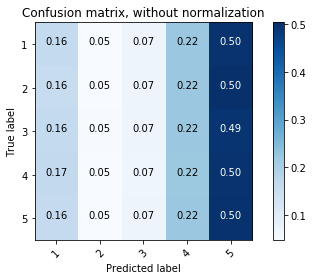

In [32]:
import time
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, max_iter=100, random_state=42).fit(np.stack(X_train), y_train.values)
pred = clf.predict(np.stack(X_test))
scores = cross_val_score(clf, np.stack(X_train), y_train.values, cv=5)

def RMSE(pred, actual):
  squared_error = np.sum((pred - actual) **2)
  mean_squared_error = squared_error / actual.size
  return pow(mean_squared_error, 0.5)

def accuracy(pred, actual):
  return np.sum(pred == actual) / actual.size

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test.values, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix, without normalization')


print('RMSE:', RMSE(pred, y_test.values))
print('Accuracy:', accuracy(pred, y_test.values))
print('Cross validation scores:', scores)

## Try 2: Adding class weights
We've also tried to add weights equal to the labels distribution in the dataset.

In [101]:
distribution = (train.groupby('stars', squeeze=True).count() / len(train)).values
class_weights = {(key+1): dist for key, dist in zip(range(0,5), distribution[:,0])}

Normalized confusion matrix
RMSE: 2.0825782098159005
Accuracy: 0.349092


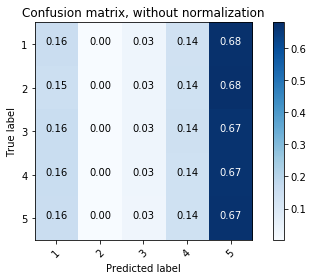

In [103]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, max_iter=100, random_state=42, class_weight=class_weights).fit(np.stack(X_train), y_train.values)
pred = clf.predict(np.stack(X_test))

cnf_matrix = confusion_matrix(y_test.values, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix, without normalization')


print('RMSE:', RMSE(pred, y_test.values))
print('Accuracy:', accuracy(pred, y_test.values))

# Try 3: Inverted class weights (Rare ranks gets higher weights)

In [105]:
distribution = (train.groupby('stars', squeeze=True).count() / len(train)).values
inverted_distribution = (1/distribution[:,0])/sum(1/distribution[:,0])
class_weights = {(key+1): dist for key, dist in zip(range(0,5), inverted_distribution)}

Normalized confusion matrix
RMSE: 2.0380206083354504
Accuracy: 0.25238


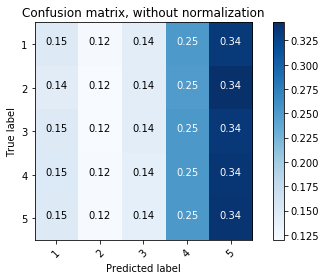

In [107]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, max_iter=100, random_state=42, class_weight=class_weights).fit(np.stack(X_train), y_train.values)
pred = clf.predict(np.stack(X_test))

cnf_matrix = confusion_matrix(y_test.values, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix, without normalization')


print('RMSE:', RMSE(pred, y_test.values))
print('Accuracy:', accuracy(pred, y_test.values))